In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/dataset'

/content/drive/MyDrive/Colab Notebooks/dataset


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import nltk
nltk.download('stopwords')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Data Preprocessing**

In [ ]:
zomato_data=pd.read_csv("Testdata.csv")
zomato_df=zomato_data.copy()

In [ ]:
zomato_df.shape

(51717, 17)

In [ ]:
zomato_df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [ ]:
zomato_df.isna().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [ ]:
#Dropping the column "dish_liked", "phone", "url"
zomato_df=zomato_df.drop(['url','book_table','online_order','phone','menu_item'],axis=1)
#Remove the NaN values from the dataset
zomato_df.dropna(how='any',inplace=True)
#Removing the Duplicates
zomato_df.duplicated().sum()
zomato_df.drop_duplicates(inplace=True)


In [ ]:
#Changing the column names
zomato_df = zomato_df.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type', 'listed_in(city)':'city'})
#Removing '/5' from Rates
zomato_df = zomato_df.loc[zomato_df.rate !='NEW']
zomato_df = zomato_df.loc[zomato_df.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
zomato_df.rate = zomato_df.rate.apply(remove_slash).str.strip().astype('float')
#Changing the cost to string
zomato_df['cost'] = zomato_df['cost'].astype(str) 
zomato_df['cost'] = zomato_df['cost'].apply(lambda x: x.replace(',','.'))
zomato_df['cost'] = zomato_df['cost'].astype(float)

In [ ]:
zomato_df.shape[0]

41233

In [ ]:
zomato_df.isna().sum()

address         0
name            0
online_order    0
book_table      0
rate            0
votes           0
location        0
rest_type       0
cuisines        0
cost            0
reviews_list    0
type            0
city            0
dtype: int64

In [ ]:
## Computing Mean Rating
restaurants = list(zomato_df['name'].unique())
zomato_df['Mean Rating'] = 0
for i in range(len(restaurants)):
    zomato_df['Mean Rating'][zomato_df['name'] == restaurants[i]] = zomato_df['rate'][zomato_df['name'] == restaurants[i]].mean()   
#Scaling the mean rating values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,5))
zomato_df[['Mean Rating']] = scaler.fit_transform(zomato_df[['Mean Rating']]).round(2)

In [ ]:
zomato_df.head(5)

,address,name,rate,votes,location,rest_type,dish_liked,cuisines,cost,reviews_list,type,city,Mean Rating
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,4.1,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Buffet,Banashankari,3.99
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,4.1,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",Buffet,Banashankari,3.97
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,3.8,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",Buffet,Banashankari,3.58
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,3.7,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",Buffet,Banashankari,3.45
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,3.8,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",Buffet,Banashankari,3.58


In [ ]:
zomato_df["reviews_list"]= zomato_df["reviews_list"].str.replace('RATED', '')
zomato_df["reviews_list"]= zomato_df["reviews_list"].replace(r'\\n',  ' ', regex=True)
zomato_df["reviews_list"] = zomato_df["reviews_list"].str.replace('Rated', '')
zomato_df["reviews_list"] = zomato_df["reviews_list"].str.replace('\d+', '')

In [ ]:
zomato_df = zomato_df.sample(frac=0.6)

In [ ]:
zomato_df.to_csv("clean.csv")

In [ ]:
zomato_df =pd.read_csv("clean.csv")
bert_df =zomato_df.copy()

In [ ]:
## Lower Casing
zomato_df["reviews_list"] = zomato_df["reviews_list"].str.lower()

## Removal of Puctuations
import string
PUNCT_TO_REMOVE = string.punctuation
zomato_df["reviews_list"] = zomato_df["reviews_list"].str.replace('[^\w\s]',' ')
# Removal of Stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
zomato_df["reviews_list"] = zomato_df["reviews_list"].apply(lambda text: remove_stopwords(text))
#Cleaning URL
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
zomato_df["reviews_list"] = zomato_df["reviews_list"].apply(lambda text: remove_urls(text))



In [ ]:
zomato_df= zomato_df.loc[zomato_df['reviews_list']!='']

In [ ]:
df_percent =zomato_df
df_percent.to_csv("df_percent.csv")

# **TF-IDF**

In [ ]:
df_percent =pd.read_csv('df_percent.csv')
df_percent.set_index('cuisines', inplace=True)
indices = pd.Series(df_percent.index)

In [ ]:
# import required modules
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
India  is a noun.


In [ ]:
# Creating tf-idf matrix
corpus = list(df_percent['reviews_list'])
tfidf = TfidfVectorizer(analyzer='word',min_df=0, stop_words='english')
tfidf.fit(corpus)
tfidf_matrix = tfidf.transform(corpus)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
def recommend(name, cosine_similarities = cosine_similarities):
   
    recommend_restaurant = []
    
    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]
    #test for accuracy 

    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:51].index)
    
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['name','Mean Rating', 'cost'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['name','Mean Rating', 'cost']][df_percent.index == each].sample()))
    
    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['name','Mean Rating', 'cost'], keep=False)
    df_new = df_new.loc[df_new['Mean Rating']>=3]
    df_new = df_new.sort_values(by='Mean Rating', ascending=False)
    
    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))
    return df_new

In [ ]:
recommend("North Indian, Chinese, Biryani") #cuisines

TOP 24 RESTAURANTS LIKE North Indian, Chinese, Biryani WITH SIMILAR REVIEWS: 


,name,Mean Rating,cost
"Chinese, Momos",The Rice Bowl,4.23,1.3
North Indian,Shuddh Desi Khana,3.93,400.0
North Indian,Puran da Dhaba - The Pride Hotel,3.83,1.7
Biryani,Mani's Dum Biryani,3.77,750.0
"North Indian, Continental",Vintage Shack,3.71,900.0
"North Indian, South Indian",Udupi Sri Krishna Cafe,3.63,600.0
"Chinese, Thai, Momos",Oogway Express,3.62,600.0
North Indian,Bihar Ki Shan,3.61,300.0
"North Indian, Mughlai",Dil Se Dilli,3.58,700.0
"North Indian, Chinese, Fast Food",Fun Kitchen,3.52,400.0


In [ ]:
import pickle
#Save vectorizer.vocabulary_
pickle.dump(cosine_similarities,open("tfidf_cosine.pkl","wb"))

In [ ]:
import pickle
#Load it later
loaded_vec = pickle.load(open("tfidf_cosine.pkl", 'rb'))

In [ ]:
def word(name, cosine_similarities = loaded_vec):
   
    recommend_restaurant = []
    
    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]
    #test for accuracy 

    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:100].index)
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['name','reviews_list','score'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['name','reviews_list']][df_percent.index == each].sample()))
    df_new['score'] =list(score_series.iloc[0:100])
    df_new = df_new.drop_duplicates(subset=['name'], keep=False)
    #df_new = df_new.loc[df_new['score']<1]
    print('TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ', name)

    from wordcloud import WordCloud
    new = df_new[['reviews_list']].head(10)
    # Start with one review:
    text = df_new['reviews_list'].head(10)
    text=text.str.cat(sep=' ')
    # import required modules
    import nltk
    nltk.download('averaged_perceptron_tagger')
    import nltk
    nltk.download('punkt')
    # function to test if something is a noun
    is_noun = lambda pos: pos[:2] == 'NN'
    # do the nlp stuff
    tokenized = nltk.word_tokenize(text)
    text = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
    from nltk.tokenize.treebank import TreebankWordDetokenizer
    text=TreebankWordDetokenizer().detokenize(text)
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS:  North Indian, Chinese, Biryani
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


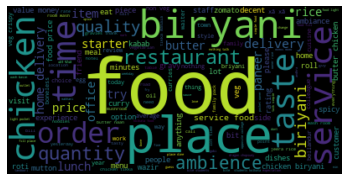

In [ ]:
word("North Indian, Chinese, Biryani") #cuisines

# **TF-IDF Evaluation**

In [ ]:
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(),index=df_percent.index,columns =tfidf.get_feature_names())
df_tfidf['rating']=df_percent['Mean Rating']

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split 
# Converting the labels from strings to binary
le = LabelEncoder()
le.fit(df_tfidf['rating'])
label = le.transform(df_tfidf['rating'])
X_train, X_test, y_train, y_test = train_test_split(df_tfidf,label,test_size=0.4,random_state=10)

**Random Forest**

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))


**********************
Precision= 0.87
Recall= 0.82
F1= 0.82
Accuracy= 0.82


**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred=nb.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

**********************
Precision= 0.89
Recall= 0.88
F1= 0.88
Accuracy= 0.88


**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

**********************
Precision= 0.73
Recall= 0.71
F1= 0.71
Accuracy= 0.71


# **BERT**

In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 5.5 MB/s 
     |████████████████████████████████| 3.1 MB 35.3 MB/s 
     |████████████████████████████████| 3.3 MB 30.0 MB/s 
     |████████████████████████████████| 1.2 MB 65.8 MB/s 
     |████████████████████████████████| 59 kB 7.2 MB/s 
     |████████████████████████████████| 596 kB 58.3 MB/s 
     |████████████████████████████████| 895 kB 75.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=f8ed4269db9f618857c2902821f62a5b9358fd632a19a2746be09291906de074
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#Remove the NaN values from the dataset
bert_df.dropna(how='any',inplace=True)

In [ ]:
#Dropping the column "dish_liked", "phone", "url"
bert_df=bert_df.drop(['url','dish_liked','phone','menu_item'],axis=1)
#Remove the NaN values from the dataset
bert_df.dropna(how='any',inplace=True)
#Removing the Duplicates
bert_df.duplicated().sum()
bert_df.drop_duplicates(inplace=True)
#Changing the column names
bert_df = bert_df.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type', 'listed_in(city)':'city'})
#Removing '/5' from Rates
bert_df = bert_df.loc[bert_df.rate !='NEW']
bert_df = bert_df.loc[bert_df.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
bert_df.rate = bert_df.rate.apply(remove_slash).str.strip().astype('float')
#Changing the cost to string
bert_df['cost'] = bert_df['cost'].astype(str) 
bert_df['cost'] = bert_df['cost'].apply(lambda x: x.replace(',','.'))
bert_df['cost'] = bert_df['cost'].astype(float)

In [ ]:
## Computing Mean Rating
restaurants = list(bert_df['name'].unique())
bert_df['Mean Rating'] = 0
for i in range(len(restaurants)):
    bert_df['Mean Rating'][bert_df['name'] == restaurants[i]] = bert_df['rate'][bert_df['name'] == restaurants[i]].mean()   
#Scaling the mean rating values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,5))
bert_df[['Mean Rating']] = scaler.fit_transform(bert_df[['Mean Rating']]).round(2)

In [ ]:
bert_df["reviews_list"]= bert_df["reviews_list"].str.replace('RATED', '')
bert_df["reviews_list"]= bert_df["reviews_list"].replace(r'\\n',  ' ', regex=True)
bert_df["reviews_list"] = bert_df["reviews_list"].str.replace('Rated', '')


In [ ]:
bert_df['reviews_list'] = bert_df['reviews_list'].str[10:]

In [ ]:
bert_df["reviews_list"] = bert_df["reviews_list"].str.replace(r'\[\(',  ' ', regex=True)
bert_df["reviews_list"] = bert_df["reviews_list"].str.replace(r'\)\]',  ' ', regex=True)

In [ ]:
bert_df= bert_df.loc[bert_df['reviews_list']!='']

In [ ]:
bert_df.shape

(13845, 14)

In [ ]:
bert_df['reviews_list'].head()

0     A beautiful place to dine in.The interiors ta...
1     Had been here for dinner with family. Turned ...
2     Ambience is not that good enough and it's not...
3     Great food and proper Karnataka style full me...
4     Very good restaurant in neighbourhood. Buffet...
Name: reviews_list, dtype: object

In [ ]:
sentence_embeddings = bert.encode(bert_df['reviews_list'].tolist())

In [ ]:
cosine_similarities = cosine_similarity(sentence_embeddings, sentence_embeddings)

In [ ]:
import pickle
#Save vectorizer.vocabulary_
pickle.dump(cosine_similarities,open("BERT_cosine.pkl","wb"))

In [ ]:
#Load it later
loaded_vec = pickle.load(open("BERT_cosine.pkl", 'rb'))

In [ ]:
def recommend(name, cosine_similarities = loaded_vec):
   
    recommend_restaurant = []
    
    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]
    #test for accuracy 

    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:100].index)
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(bert_df.index)[each])
    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['cuisines','name','reviews_list','score'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(bert_df[['cuisines','name','reviews_list']][bert_df.index == each].sample()))
    df_new['score'] =list(score_series.iloc[0:100])
    df_new = df_new.drop_duplicates(subset=['name'], keep=False)
    df_new = df_new.loc[df_new['score']<1]
    print('TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ', name)
    return df_new.head(10)

In [ ]:
recommend("North Indian, Chinese, Biryani") #cuisines

TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS:  North Indian, Chinese, Biryani


,cuisines,name,reviews_list,score
8336,"Andhra, Chinese, Biryani",Delight Food,Came as hunger saviour at night 2 AM....... O...,0.931813
39285,"Biryani, North Indian",Biryani Miya,When I felt hungry in the midnight. I always ...,0.929926
41036,"North Indian, Chinese, Continental, Biryani, Thai",BHR Foods,Ordered chicken schezwan noodles and chilli c...,0.929849
12213,"Fast Food, Rolls, Momos",Pathaan Sir,Visited here last Friday.Tried to have hot mo...,0.929728
8933,"North Indian, Chinese",Mak n Vak - Fyn,Ordered chilli chicken. It Was so good and ta...,0.928851
19251,"North Indian, Chinese",Punjabi Tadka,Been here multiple times with my friends. If ...,0.928682
19076,"Fast Food, Desserts",Sarah's,The chicken burger & veg burger combos were v...,0.927474
19273,"North Indian, South Indian, Chinese, Continental",DinePost9,A recent favourite for late night eats... we ...,0.927416
11132,"Kerala, Biryani, South Indian, North Indian, C...",Thalassery Restaurant,"I had ordered butter naan, tandoori chicken, ...",0.926721
39174,"Biryani, Fast Food",Biriyani Adda,Last night I was craving for some good foods ...,0.924374


TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS:  North Indian, Chinese, Biryani
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


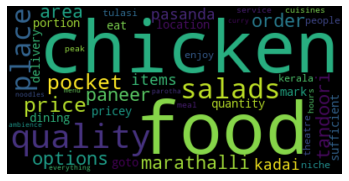

In [ ]:
word("North Indian, Chinese, Biryani") #cuisines

# **BERT evaluation**

In [ ]:
df_b = pd.DataFrame(sentence_embeddings,index=bert_df.index)
df_b['rating']=bert_df['Mean Rating']

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split 
# Converting the labels from strings to binary
le = LabelEncoder()
le.fit(df_b['rating'])
label = le.transform(df_b['rating'])
X_train, X_test, y_train, y_test = train_test_split(df_b,label,test_size=0.4,random_state=10)

**Random Forest**

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))


**********************
Precision= 0.87
Recall= 0.84
F1= 0.84
Accuracy= 0.84


**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred=nb.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

**********************
Precision= 1.00
Recall= 1.00
F1= 1.00
Accuracy= 1.00


**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

**********************
Precision= 0.73
Recall= 0.72
F1= 0.72
Accuracy= 0.72


# **CountVectorizer**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer(analyzer='word',min_df=0, stop_words='english') 
count_matrix = cv.fit_transform(df_percent["reviews_list"])

In [ ]:
df_cv = pd.DataFrame(count_matrix.toarray(),index=df_percent.index,columns =cv.get_feature_names())
df_cv['rating']=df_percent['Mean Rating']


In [ ]:
cosine_similarities = cosine_similarity(count_matrix, count_matrix)

In [ ]:
import pickle
#Save vectorizer.vocabulary_
pickle.dump(cosine_similarities,open("CV_cosine.pkl","wb"))

In [ ]:
#Load it later
loaded_vec = pickle.load(open("CV_cosine.pkl", 'rb'))

In [ ]:
def recommend(name, cosine_similarities = loaded_vec):
   
    recommend_restaurant = []
    
    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]
    #test for accuracy 

    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:100].index)
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['name','reviews_list','score'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['name','reviews_list']][df_percent.index == each].sample()))
    df_new['score'] =list(score_series.iloc[0:100])
    df_new = df_new.drop_duplicates(subset=['name'], keep=False)
    df_new = df_new.loc[df_new['score']<1]
    print('TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ', name)
    return df_new.head(10)

In [ ]:
recommend("North Indian, Chinese, Biryani") #cuisines

TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS:  North Indian, Chinese, Biryani


,name,reviews_list,score
"North Indian, Chinese, Biryani",RR Catering,really felt like good get india always looking...,1.000000
"North Indian, Chinese, Biryani",Hyderabad Biryaani Palace,good order delivered loved satisfied ã xã xã x...,0.994480
"Biryani, North Indian, Chinese",Hyderabadi Biryani Hub,usually order chicken biryani tasty little bit...,0.847098
"North Indian, Chinese",Lovely Knights,food nice mixed north indian flavor thali one ...,0.836869
Chinese,Chungs Pavilion,visiting place since never ever disappointed e...,0.832245
Chinese,Hongkong Noodles,ordered chicken fried rice crazy quantity plat...,0.832158
"North Indian, Chinese",Night Food Joint,ordered tandoori chicken naan zomato delivery ...,0.829420
"North Indian, Biryani, Chinese",Sri Sai Mango Tree Restaurant,food eatable taste wise items ok lot starters ...,0.826764
"North Indian, Chinese",Sufra Restaurant,worst experience sufra restaurant friday night...,0.826256
"North Indian, Chinese",Parivar,going yrs still preferred place quality mainta...,0.826253


TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS:  North Indian, Chinese, Biryani
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


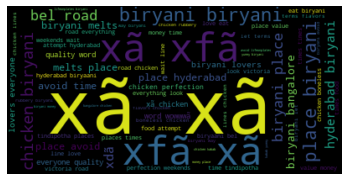

In [ ]:
word("North Indian, Chinese, Biryani") #cuisines #noun

# **CountVectorizer evaluation**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split 
# Converting the labels from strings to binary
le = LabelEncoder()
le.fit(df_cv['rating'])
label = le.transform(df_cv['rating'])
X_train, X_test, y_train, y_test = train_test_split(df_cv,label,test_size=0.4,random_state=10)

**Random Forest**

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))


**********************
Precision= 0.83
Recall= 0.78
F1= 0.78
Accuracy= 0.78


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred=nb.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

**********************
Precision= 0.71
Recall= 0.58
F1= 0.59
Accuracy= 0.58


**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

**********************
Precision= 0.68
Recall= 0.65
F1= 0.66
Accuracy= 0.65


# **Word2Vec**

In [ ]:
corpus = []
for words in df_percent['reviews_list']:
    corpus.append(words.split())

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Downloading the Google pretrained Word2Vec Model
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# Training our corpus with Google Pretrained Model

google_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)

#model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

--2021-11-28 05:27:51--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.37.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.37.222|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



(0, 0)

In [ ]:
# Creating a list for storing the vectors (description into vectors)
global word_embeddings
word_embeddings = []

    # Reading the each book description 
for line in df_percent['reviews_list']:
  avgword2vec = None
  count = 0
  for word in line.split():
      if word in google_model.wv.vocab:
          count += 1
          if avgword2vec is None:
              avgword2vec = google_model[word]
          else:
              avgword2vec = avgword2vec + google_model[word]
                
  if avgword2vec is not None:
      avgword2vec = avgword2vec / count
        
      word_embeddings.append(avgword2vec)


In [ ]:
df_w = pd.DataFrame(word_embeddings,index=df_percent.index)
df_w['rating']=df_percent['Mean Rating']

In [ ]:
cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

In [ ]:
import pickle
#Save vectorizer.vocabulary_
pickle.dump(cosine_similarities,open("W2V_cosine.pkl","wb"))

In [ ]:
#Load it later
import pickle
loaded_vec = pickle.load(open("W2V_cosine.pkl", 'rb'))

In [ ]:
def recommend(name, cosine_similarities = loaded_vec):
   
    recommend_restaurant = []
    
    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]
    #test for accuracy 

    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:100].index)
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['name','reviews_list','score'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['name','reviews_list']][df_percent.index == each].sample()))
    df_new['score'] =list(score_series.iloc[0:100])
    df_new = df_new.drop_duplicates(subset=['name'], keep=False)
    #df_new = df_new.loc[df_new['score']<1]
    print('TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ', name)
    return df_new.head(10)

In [ ]:
recommend("North Indian, Chinese, Biryani") #cuisines

TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS:  North Indian, Chinese, Biryani


,name,reviews_list,score
"North Indian, Chinese, Biryani",Punjabi Tasty Khana,bad quality food order maharaja special thali ...,1.000000
"North Indian, Chinese, Biryani",Polamma's Mess,polammas mess situated right opposite christ u...,0.999498
"North Indian, Biryani, Chinese",New Punjabi Tasty Khana,got offer ordered pulao corn manchurian combo ...,0.991841
"North Indian, Chinese",Mint Masala,visit mint masala visit hospital next door fam...,0.991762
"North Indian, Biryani, Chinese",Indus Family Restaurant,food great chicken tasty rice ok vegetarian st...,0.991650
"Biryani, North Indian, Chinese",Hyderabadi Biryani Hub,friend ordered fried chicken biryani taste goo...,0.991617
"North Indian, Chinese",Sathya's,friendly neighborhood bar delicious food good ...,0.991479
"North Indian, Chinese",Shyvan Restaurant,went lunch tried fried rice noodles good laydo...,0.991224
"North Indian, Chinese",Paratha Junction,ordered pizza paratha paneer paratha really ba...,0.991205
"North Indian, Chinese",Just Yum,ordered veg hakka noodles place delivery quick...,0.991192


TOP 10 RESTAURANTS LIKE %s WITH SIMILAR REVIEWS:  North Indian, Chinese, Biryani
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


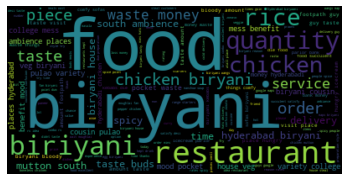

In [ ]:
word("North Indian, Chinese, Biryani") #cuisines #noun

# **Word2Vec evaluation**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split 
# Converting the labels from strings to binary
le = LabelEncoder()
le.fit(df_w['rating'])
label = le.transform(df_w['rating'])
X_train, X_test, y_train, y_test = train_test_split(df_w,label,test_size=0.4,random_state=10)

**Random Forest**

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))


**********************
Precision= 0.84
Recall= 0.79
F1= 0.78
Accuracy= 0.79


**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred=nb.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

**********************
Precision= 0.99
Recall= 1.00
F1= 0.99
Accuracy= 1.00


**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred,average='weighted')))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred,average='weighted')))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred,average='weighted')))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

**********************
Precision= 0.71
Recall= 0.70
F1= 0.69
Accuracy= 0.70
